# Serving Megadetector with Sagemaker Serverless

This nb is adapted from 
https://github.com/aws-samples/amazon-sagemaker-endpoint-deployment-of-fastai-model-with-torchserve

It takes an existing .mar torchserve package from the animl-model-zoo, places it in a prod bucket, and serves it with a Sagemaker Serverless Endpoint.

In [1]:
%reload_ext autoreload
%autoreload 2


%matplotlib inline

## Boilerplate

### Session

In [1]:
import boto3, time, json
from PIL import Image
import sagemaker

sess = boto3.Session()
sm = sess.client("sagemaker")
region = sess.region_name
account = boto3.client("sts").get_caller_identity().get("Account")

### IAM Role

**Note**: make sure the IAM role has:  
- `AmazonS3FullAccess`  
- `AmazonEC2ContainerRegistryFullAccess`  
- `AmazonSageMakerFullAccess`  

In [2]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::830244800171:role/service-role/AmazonSageMaker-ExecutionRole-20210125T212674'

### Amazon Elastic Container Registry (ECR)

**Note**: create ECR if it doesn't exist

In [3]:
registry_name = "torchserve-mdv5-sagemaker"

In [4]:
!aws ecr create-repository --repository-name {registry_name}


An error occurred (RepositoryAlreadyExistsException) when calling the CreateRepository operation: The repository with name 'torchserve-mdv5-sagemaker' already exists in the registry with id '830244800171'


In [5]:
image = f"{account}.dkr.ecr.{region}.amazonaws.com/{registry_name}:latest"
image

'830244800171.dkr.ecr.us-west-2.amazonaws.com/torchserve-mdv5-sagemaker:latest'

### Pytorch Model Artifact

Create a compressed `*.tar.gz` file from the `*.mar` file per requirement of Amazon SageMaker and upload the model to your Amazon S3 bucket.

In [6]:
model_prefix = "megadetectorv5-yolov5-1-batch-640-640"
model_uri = f's3://animl-model-zoo/megadetectorv5/{model_prefix}.mar'
sagemaker_session = sagemaker.Session(boto_session=sess)
bucket_name = sagemaker_session .default_bucket()
prefix = 'torchserve'
prod_model_uri = f"s3://{bucket_name}/{prefix}/models/"

In [13]:
!aws s3 cp {model_uri} ./

!tar cvfz {model_prefix}.tar.gz {model_prefix}.mar

!aws s3 cp {model_prefix}.tar.gz {prod_model_uri}

download: s3://animl-model-zoo/megadetectorv5/megadetectorv5-yolov5-1-batch-640-640.mar to ./megadetectorv5-yolov5-1-batch-640-640.mar
megadetectorv5-yolov5-1-batch-640-640.mar
upload: ./megadetectorv5-yolov5-1-batch-640-640.tar.gz to s3://sagemaker-us-west-2-830244800171/torchserve/models/megadetectorv5-yolov5-1-batch-640-640.tar.gz


### Build a TorchServe Docker container and push it to Amazon ECR

**Skip this step if the registry is already made and the custom latest pytorch container is already pushed since this step takes a couple of minutes**

In [16]:
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account}.dkr.ecr.{region}.amazonaws.com
!docker build -t {registry_name} ../
!docker tag {registry_name} {image}
!docker push {image}

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  911.2MB
Step 1/16 : FROM pytorch/pytorch:1.11.0-cuda11.3-cudnn8-runtime
 ---> ca04e7f7c8e5
Step 2/16 : ENV PYTHONUNBUFFERED TRUE
 ---> Using cache
 ---> 527808f8e555
Step 3/16 : RUN apt-get update && apt-get install -y software-properties-common rsync
 ---> Using cache
 ---> 239e53b2c212
Step 4/16 : RUN add-apt-repository -y ppa:git-core/ppa && apt-get update && apt-get install -y git libglib2.0-dev && apt-get update
 ---> Using cache
 ---> 2b54c15ff159
Step 5/16 : RUN DEBIAN_FRONTEND=noninteractive apt-get install --no-install-recommends -y     fakeroot     ca-certificates     dpkg-dev     g++     openjdk-11-jdk     curl     vim     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> d3b28eae8d7c
Step 6/1

### Model

In [17]:
model_data = f"{prod_model_uri}{model_prefix}.tar.gz"
model_already_created = False
for model_def in sm.list_models()['Models']:
    if model_prefix == model_def['ModelName']:
        create_model_response = model_def
        model_already_created = True

In [18]:
container = {"Image": image, "ModelDataUrl": model_data}

if not model_already_created:
    create_model_response = sm.create_model(
        ModelName=model_prefix, ExecutionRoleArn=role, PrimaryContainer=container
    )

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-west-2:830244800171:model/megadetectorv5-yolov5-1-batch-640-640


## Inference Endpoint

### Endpoint configuration

**Note**: choose your preferred `InstanceType`: https://aws.amazon.com/sagemaker/pricing/

### Serverless Config (this adds the serverless config section and removes instance type and size specs from the original notebook)

In [19]:
import time

endpoint_config_name = "torchserve-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(endpoint_config_name)

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "ModelName": model_prefix,
            "VariantName": "AllTraffic",
            "ServerlessConfig": {
            "MemorySizeInMB": 2048,
            "MaxConcurrency": 5
            }
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

torchserve-endpoint-config-2022-06-24-00-25-21
Endpoint Config Arn: arn:aws:sagemaker:us-west-2:830244800171:endpoint-config/torchserve-endpoint-config-2022-06-24-00-25-21


### Endpoint

In [20]:
endpoint_name = "torchserve-endpoint-serverless" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(endpoint_name)

create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

torchserve-endpoint-serverless2022-06-24-00-25-22
arn:aws:sagemaker:us-west-2:830244800171:endpoint/torchserve-endpoint-serverless2022-06-24-00-25-22


In [ ]:
%%time
resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating


In [24]:
resp

{'EndpointName': 'torchserve-endpoint-serverless2022-06-24-00-25-22',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:830244800171:endpoint/torchserve-endpoint-serverless2022-06-24-00-25-22',
 'EndpointConfigName': 'torchserve-endpoint-config-2022-06-24-00-25-21',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '830244800171.dkr.ecr.us-west-2.amazonaws.com/torchserve-mdv5-sagemaker:latest',
     'ResolvedImage': '830244800171.dkr.ecr.us-west-2.amazonaws.com/torchserve-mdv5-sagemaker@sha256:b18c86b0597d0d42dc805dd4f53512eebb0999a9f8512401fda7ab4605745490',
     'ResolutionTime': datetime.datetime(2022, 6, 24, 0, 25, 24, 217000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 2048, 'MaxConcurrency': 5}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2022, 6, 24, 0, 25, 22, 520000, tzinfo=tzlocal()),
 'LastModifiedTime': da

### Testing

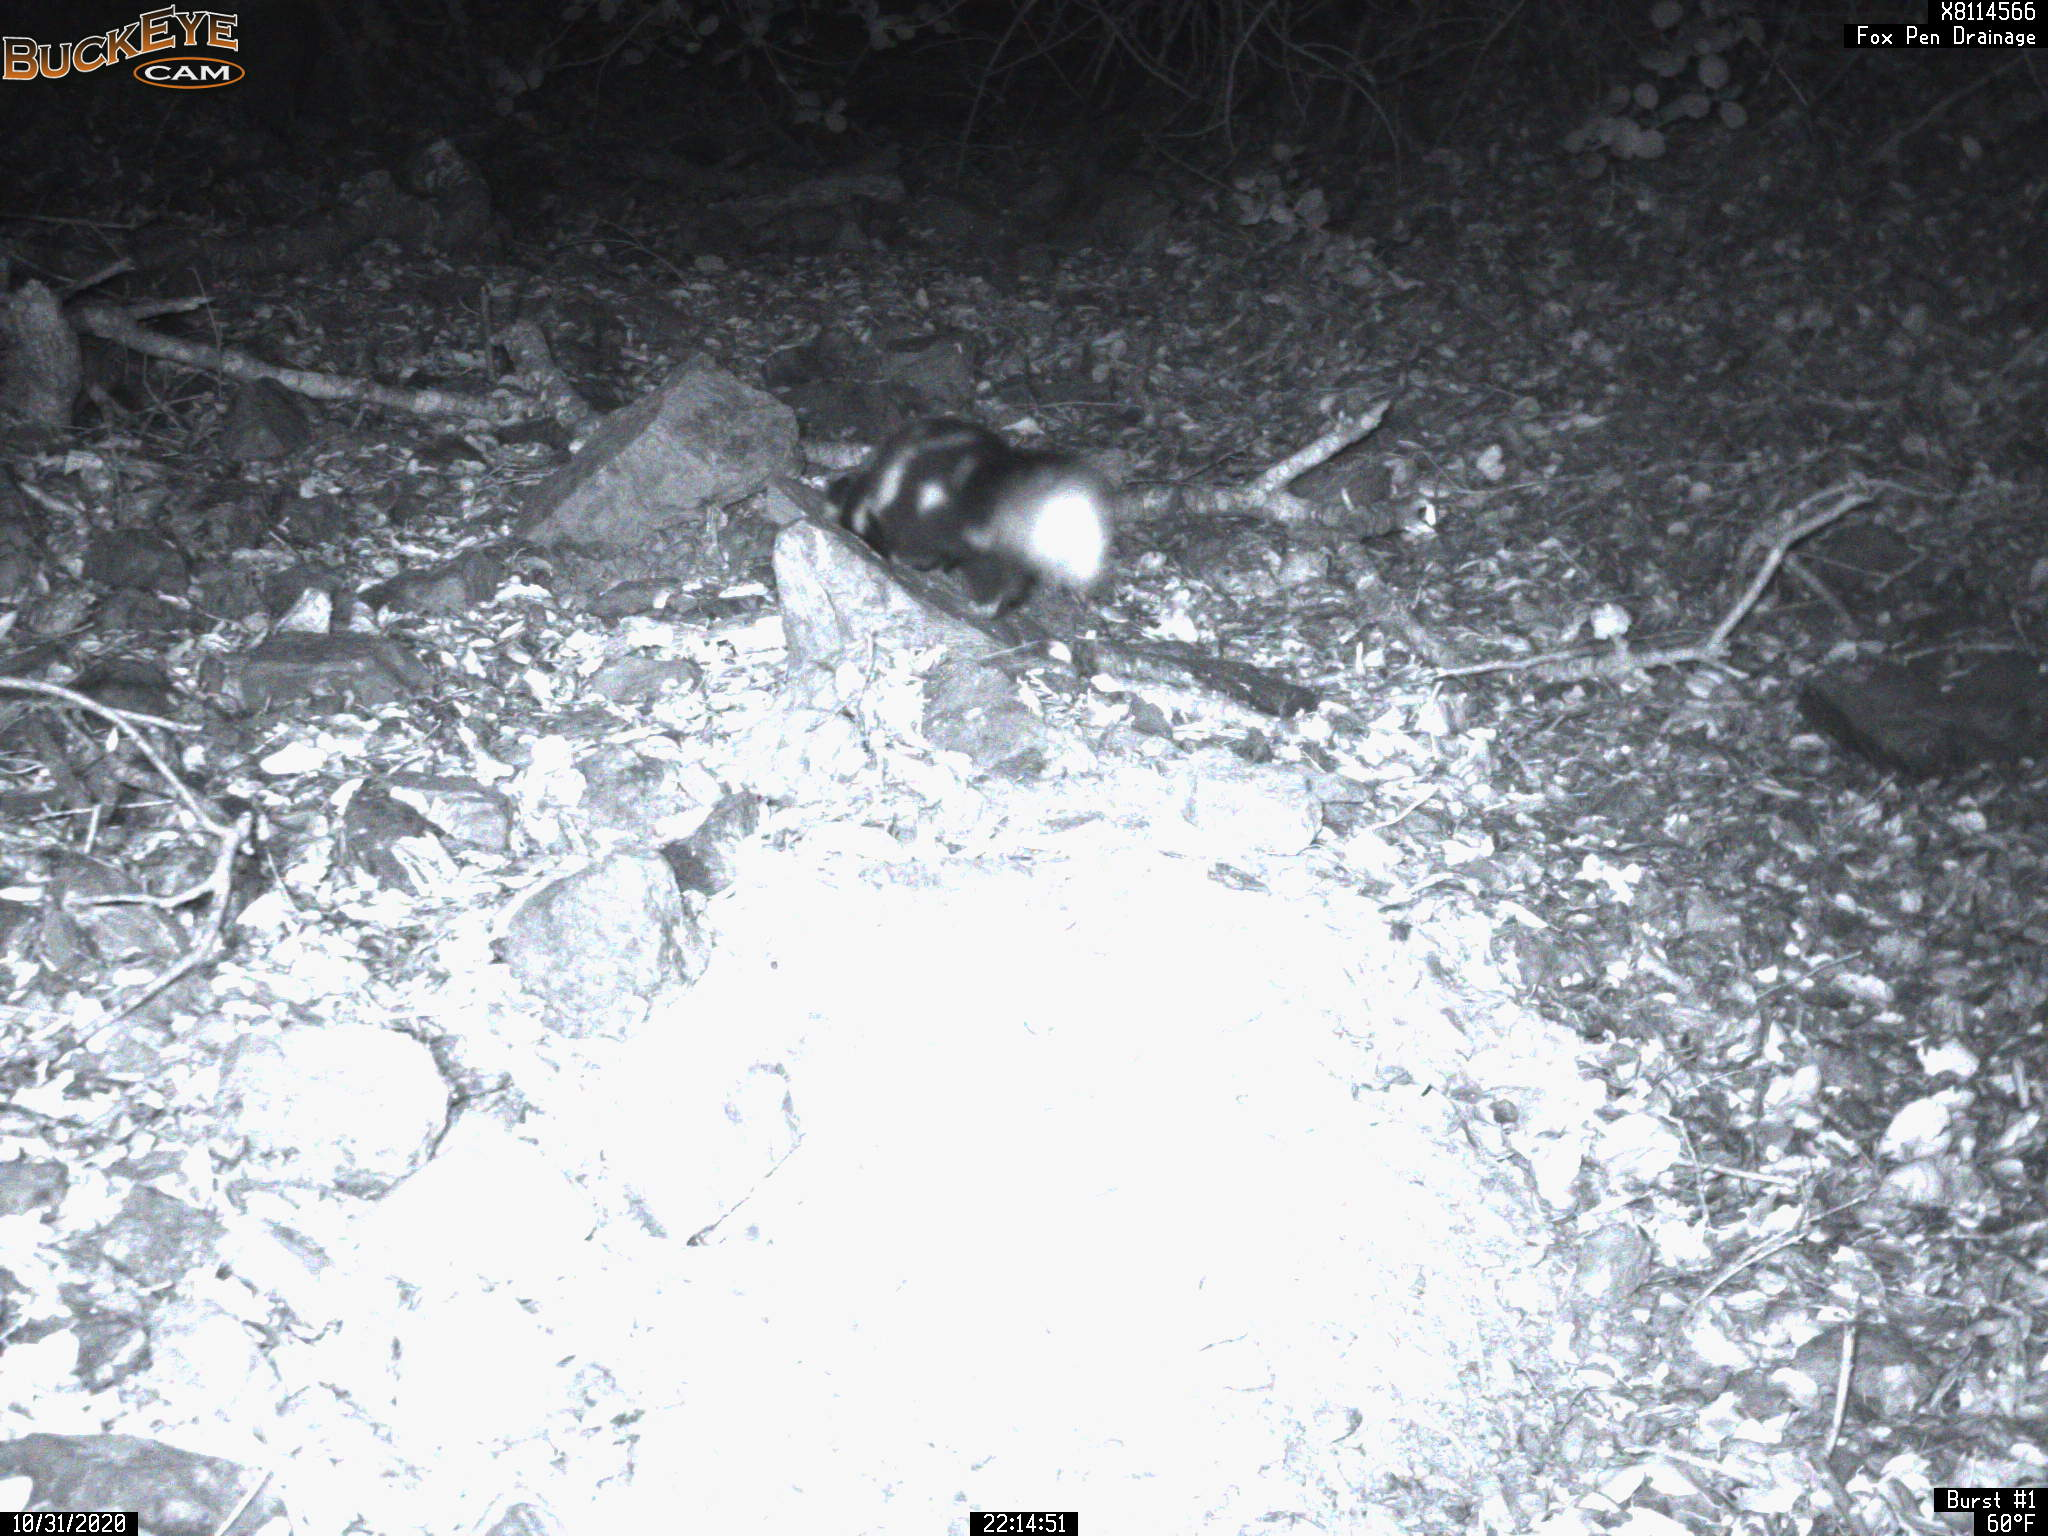

In [32]:
from io import BytesIO
payload = boto3.client("s3").get_object(Bucket="animl-sample-images", Key="p_000610.jpg")['Body'].read()
Image.open(BytesIO(payload))

In [33]:
%%time
client = boto3.client("runtime.sagemaker")
response = client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
)
response = json.loads(response["Body"].read())

CPU times: user 37.9 ms, sys: 938 µs, total: 38.8 ms
Wall time: 1min 28s


In [34]:
response

[{'x1': 0.4013262689113617,
  'y1': 0.268169105052948,
  'x2': 0.546728789806366,
  'y2': 0.40511518716812134,
  'confidence': 0.869147002696991,
  'class': 0}]

### Cleanup

In [39]:
client = boto3.client("sagemaker")
client.delete_model(ModelName=sm_model_name)
client.delete_endpoint(EndpointName=endpoint_name)
client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': 'a1a8a063-c25c-4f99-94ef-770d927448a4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a1a8a063-c25c-4f99-94ef-770d927448a4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 23 Jun 2022 23:23:44 GMT'},
  'RetryAttempts': 0}}

In [37]:
### weird error, create model expects arn satisfying a different reg expression than create inf recommender. "model" vs "model-package" in the reg expression requirement.

# job_name = "mdv5-recommender"
# job_type = "Default"
# sm.create_inference_recommendations_job(
#     JobName = job_name,
#     JobType = job_type,
#     RoleArn = role,
#     InputConfig = {
#         'ModelPackageVersionArn': create_model_response["ModelArn"]
#     }
# )

ClientError: An error occurred (ValidationException) when calling the CreateInferenceRecommendationsJob operation: Provided model package ARN is invalid with the following error: ModelPackage arn:aws:sagemaker:us-west-2:830244800171:model-package/megadetectorv5-yolov5-1-batch-640-640 does not exist. (Service: AmazonSageMaker; Status Code: 400; Error Code: ValidationException; Request ID: 51d6c786-35e7-44e7-a4e6-905f1581560e; Proxy: null)